# Artist Recommender
## Derek Hu | COEN 140 | March 23, 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Retrieve & Format Data

In [2]:
data = pd.DataFrame.from_csv('song_data.csv', sep=',', index_col=None)

audio_features = pd.DataFrame.from_csv('spotify.csv', sep=',', index_col=None)
audio_features = audio_features.drop(['id', 'analysis_url', 'duration_ms', 'track_href', 'type', 'uri', 'mode'], axis = 1)
audio_features = audio_features.dropna()

songs = pd.DataFrame(audio_features.loc[:,['song']].values, columns=['song']).set_index('song')

audio_features = audio_features.set_index('song')

### Get list of songs grouped by artist

In [3]:
songs_per_artist = []
for i in data['artist'].unique():
    songs_per_artist.append(data.loc[data['artist'] == i]['song'].unique())

### Compute averages of audio features from all of an artist's songs

In [4]:
avg_audio_features = pd.DataFrame(columns=['acousticness', 'danceability', 'energy', 'instrumentalness'
        , 'key', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence'])

for i in range(len(songs_per_artist)):
    Sum = np.zeros((11,1))
    for j in songs_per_artist[i]:
        if j in audio_features.index:
            for k in range(len(audio_features.loc[j])):
                Sum[k] += audio_features.loc[j][k]
    Sum = (Sum / len(songs_per_artist[i]))
    avg_audio_features = avg_audio_features.append(pd.DataFrame(data=Sum.T, columns=['acousticness', 'danceability', 'energy', 'instrumentalness'
        , 'key', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence']))
    
avg_audio_features['artist'] = data['artist'].unique()
avg_audio_features = avg_audio_features.set_index('artist')
avg_audio_features = avg_audio_features[(avg_audio_features.T != 0).any()]

std_audio_features = StandardScaler().fit_transform(avg_audio_features)

In [5]:
artist_matrix = pd.pivot_table(data, index = 'artist', columns = 'user_id', values = 'listen_count', fill_value = 0)

artist_knn = NearestNeighbors(metric='cosine', algorithm='brute')
artist_knn.fit(artist_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

## Set up K-Means

### Check Elbow Point for optimal K

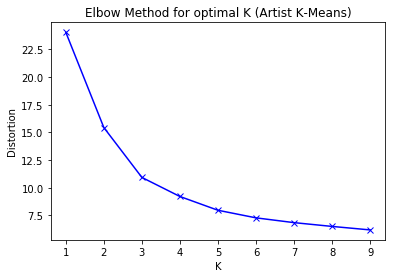

In [15]:
kmn_distortion = []
K = range(1,10)
for k in K:
    kmn_model = KMeans(n_clusters = k).fit(audio_features)
    kmn_distortion.append(sum(np.min(cdist(audio_features, kmn_model.cluster_centers_, 'euclidean'), axis=1)) / audio_features.shape[0])

plt.plot(K, kmn_distortion, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal K (Artist K-Means)')
plt.show()

In [7]:
kmn_n_clusters = 3
kmn = KMeans(n_clusters = kmn_n_clusters).fit(avg_audio_features)

kmn_clusters = []
for i in range(kmn_n_clusters):
    kmn_clusters.append(np.asarray([avg_audio_features.index[j] for j in np.where(kmn.labels_ == i)[0]]))

## Set up PCA + K-Means

### Check Elbow Point for optimal K

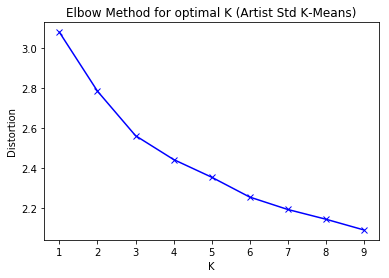

In [14]:
PCA_distortions = []
K = range(1,10)
for k in K:
    PCA_model = KMeans(n_clusters = k).fit(std_audio_features)
    PCA_distortions.append(sum(np.min(cdist(std_audio_features, PCA_model.cluster_centers_, 'euclidean'), axis=1)) / std_audio_features.shape[0])

plt.plot(K, PCA_distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal K (Artist Std K-Means)')
plt.show()

In [9]:
pca = PCA(n_components=7)
PC = pca.fit_transform(std_audio_features)

PC = pd.DataFrame(data = PC, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7']).reset_index(drop=True)
PC['artist'] = avg_audio_features.index
PCA_audio_features = PC.set_index('artist')

PCA_n_clusters = 6
PCA_kmn = KMeans(n_clusters = PCA_n_clusters)
PCA_kmn.fit(PCA_audio_features)

PCA_clusters = []
for i in range(PCA_n_clusters):
    PCA_clusters.append(np.asarray([PCA_audio_features.index[j] for j in np.where(PCA_kmn.labels_ == i)[0]]))

### Check principal component variances & total variance

In [10]:
print("Principal compoenent variances:", pca.explained_variance_ratio_)
print("Total prinicpal component variance:", sum(pca.explained_variance_ratio_))

Principal compoenent variances: [ 0.2857195   0.18363205  0.10728373  0.09657731  0.07914871  0.0769754
  0.06271713]
Total prinicpal component variance: 0.892053835515


## Recommenders

### Get base song

In [19]:
artist = input()

for i in range(kmn_n_clusters):
    if artist in kmn_clusters[i]:
        kmn_index = [i, np.where(kmn_clusters[i]==artist)[0][0]]
        break

print("K-Means - Artist found in cluster", kmn_index)

for i in range(PCA_n_clusters):
    if artist in PCA_clusters[i]:
        PCA_index = [i, np.where(PCA_clusters[i]==artist)[0][0]]
        break

print("PCA + K-Means - Artist found in cluster", PCA_index)

Kanye West
K-Means - Artist found in cluster [2, 2]
PCA + K-Means - Artist found in cluster [5, 0]


### Get matrices, distances, & indices

In [20]:
# K-NN
query = artist_matrix.index.get_loc(artist)
distances, indices = artist_knn.kneighbors(artist_matrix.iloc[query, :].values.reshape(1, -1), n_neighbors = 6)

# K-Means + K-NN
kmn_selection = pd.DataFrame(index=kmn_clusters[kmn_index[0]], data={'in': 0})
kmn_selection = data.join(kmn_selection, on='artist').dropna()

kmn_cluster_matrix = pd.pivot_table(kmn_selection, index = 'artist', columns = 'user_id', values = 'listen_count', fill_value = 0)
kmn_cluster_knn = NearestNeighbors(metric='cosine', algorithm='brute').fit(kmn_cluster_matrix)

kmn_query = kmn_cluster_matrix.index.get_loc(artist)
kmn_distances, kmn_indices = kmn_cluster_knn.kneighbors(kmn_cluster_matrix.iloc[kmn_query, :].values.reshape(1, -1), n_neighbors = 6)

# PCA + K-Means + K-NN
PCA_selection = pd.DataFrame(index=PCA_clusters[PCA_index[0]], data={'in': 0})
PCA_selection = data.join(PCA_selection, on='artist').dropna()

PCA_cluster_matrix = pd.pivot_table(PCA_selection, index = 'artist', columns = 'user_id', values = 'listen_count', fill_value = 0)

PCA_cluster_knn = NearestNeighbors(metric='cosine', algorithm='brute').fit(PCA_cluster_matrix)

PCA_query = PCA_cluster_matrix.index.get_loc(artist)
PCA_distances, PCA_indices = PCA_cluster_knn.kneighbors(PCA_cluster_matrix.iloc[PCA_query, :].values.reshape(1, -1), n_neighbors = 6)

### Give recommendations

In [21]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('K-NN Recommendations for {0}:\n'.format(artist_matrix.index[query]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, artist_matrix.index[indices.flatten()[i]], distances.flatten()[i]))

print('\n')

for i in range(0, len(kmn_distances.flatten())):
    if i == 0:
        print('K-NN with K-Means Recommendations for {0}:\n'.format(kmn_cluster_matrix.index[kmn_query]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, kmn_cluster_matrix.index[kmn_indices.flatten()[i]], kmn_distances.flatten()[i]))

print('\n')

for i in range(0, len(PCA_distances.flatten())):
    if i == 0:
        print('K-NN with K-Means & PCA Recommendations for {0}:\n'.format(PCA_cluster_matrix.index[PCA_query]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, PCA_cluster_matrix.index[PCA_indices.flatten()[i]], PCA_distances.flatten()[i]))

K-NN Recommendations for Kanye West:

1: Girl Talk, with distance of 0.8404610161158217:
2: Bayside, with distance of 0.8423386550005177:
3: Fort Minor (Featuring Styles Of Beyond), with distance of 0.8426497300628845:
4: Cidinho, with distance of 0.8952500144618121:
5: Metallica, with distance of 0.9102647000976343:


K-NN with K-Means Recommendations for Kanye West:

1: Girl Talk, with distance of 0.8404610161158217:
2: Metallica, with distance of 0.9102647000976343:
3: Sidney Samson, with distance of 0.9198834798043698:
4: David Cook, with distance of 0.9352421817178592:
5: Kanye West / Syleena Johnson, with distance of 0.9411312182299502:


K-NN with K-Means & PCA Recommendations for Kanye West:

1: Kanye West / Syleena Johnson, with distance of 0.9411312182299502:
2: Kanye West / GLC / Consequence, with distance of 0.9420467829339941:
3: Eminem, with distance of 0.9435826501731439:
4: Portugal. The Man, with distance of 0.9445781367586987:
5: Kanye West / T-Pain, with distance of 